In [ ]:
# ================== Setup (Colab/local) ==================
!pip -q install --upgrade --force-reinstall git+https://github.com/KellerJordan/Muon
!pip -q install torch torchvision torchaudio

import time, torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

# import Muon single-device wrapper
from muon import SingleDeviceMuonWithAuxAdam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# reproducibility
torch.manual_seed(0)
if device.type == "cuda":
    torch.cuda.manual_seed_all(0)


  Preparing metadata (setup.py) ... done
Device: cuda


In [ ]:
# --- CIFAR-10 normalization stats (RGB) ---
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

# --- Data: train/val (val taken from test for simplicity) ---
train_tfms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])
test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

data_root = "./data"
train_ds = torchvision.datasets.CIFAR10(root=data_root, train=True,  download=True, transform=train_tfms)
test_ds  = torchvision.datasets.CIFAR10(root=data_root, train=False, download=True, transform=test_tfms)

batch_size = 128
num_workers = 2 if device.type == "cuda" else 0
trainloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=(device.type=="cuda"))
testloader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device.type=="cuda"))


100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


In [ ]:
# ================== LR x WD Sweep with saving (epoch-based plots) ==================
import os, time, json, torch, matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models

try:
    from muon import SingleDeviceMuonWithAuxAdam as MuonWrapper
except Exception:
    from muon import MuonWithAuxAdam as MuonWrapper

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Model (ResNet-18 for CIFAR-10) ---
def resnet18_cifar(num_classes=10):
    m = models.resnet18(weights=None)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

criterion = nn.CrossEntropyLoss()

@torch.no_grad()
def evaluate(model):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    for x, y in testloader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += loss.item() * y.size(0)
        correct  += (logits.argmax(1) == y).sum().item()
        total    += y.size(0)
    return loss_sum / total, correct / total

def build_optimizer(model, lr_muon, lr_aux, wd):
    muon_params, aux_params = [], []
    for n, p in model.named_parameters():
        if not p.requires_grad:
            continue
        (muon_params if p.ndim == 2 else aux_params).append(p)
    param_groups = [
        dict(params=muon_params, use_muon=True,  lr=lr_muon, momentum=0.95, weight_decay=wd),
        dict(params=aux_params,  use_muon=False, lr=lr_aux,                 weight_decay=wd),
    ]
    return MuonWrapper(param_groups)

def train_one_epoch(model, optimizer):
    model.train()
    steps = 0
    running_loss, running_correct, running_total = 0.0, 0, 0
    for x, y in trainloader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        steps += 1
        running_loss   += loss.item() * y.size(0)
        running_correct += (logits.argmax(1) == y).sum().item()
        running_total  += y.size(0)
    train_loss = running_loss / max(1, running_total)
    train_acc  = running_correct / max(1, running_total)
    return train_loss, train_acc, steps

def fname_float(x):
    return f"{x:.3g}".replace("+", "").replace("-", "m").replace(".", "p")

# ================== Grid & Run ==================
#LR_GRID   = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
WD_GRID   = [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]


MAX_EPOCHS = 50
PATIENCE   = 5
MIN_DELTA  = 1e-3
SAVE_DIR   = "./lr_wd_results"
os.makedirs(SAVE_DIR, exist_ok=True)

results = []
histories = {}

for lr in LR_GRID:
    for wd in WD_GRID:
        torch.manual_seed(0)
        if device.type == "cuda":
            torch.cuda.manual_seed_all(0)

        model = resnet18_cifar().to(device)
        optimizer = build_optimizer(model, lr_muon=lr, lr_aux=lr, wd=wd)

        best_acc, best_epoch = 0.0, 0
        patience_left, total_steps = PATIENCE, 0
        t0 = time.time()
        val_acc_history, val_loss_history = [], []

        for epoch in range(1, MAX_EPOCHS + 1):
            train_loss, train_acc, steps = train_one_epoch(model, optimizer)
            total_steps += steps
            val_loss, val_acc = evaluate(model)
            val_acc_history.append(val_acc)
            val_loss_history.append(val_loss)

            if val_acc > best_acc + MIN_DELTA:
                best_acc, best_epoch, patience_left = val_acc, epoch, PATIENCE
            else:
                patience_left -= 1

            if epoch % 5 == 0 or epoch == 1:
                print(f"[lr={lr:.4g}, wd={wd:.4g}] epoch {epoch:02d}: "
                      f"train_loss={train_loss:.4f} acc={train_acc*100:5.2f}% | "
                      f"val_loss={val_loss:.4f} acc={val_acc*100:5.2f}% | steps={total_steps}")

            if patience_left == 0:
                break

        elapsed = time.time() - t0
        trial_summary = dict(
            lr=lr, wd=wd, best_acc=best_acc, best_epoch=best_epoch,
            epochs_run=len(val_acc_history), steps=total_steps, time_sec=elapsed
        )
        results.append(trial_summary)
        histories[(lr, wd)] = {"acc": val_acc_history, "loss": val_loss_history}

        tag = f"lr{fname_float(lr)}_wd{fname_float(wd)}"
        torch.save(
            {"val_acc": val_acc_history, "val_loss": val_loss_history, "summary": trial_summary},
            os.path.join(SAVE_DIR, f"hist_{tag}.pt")
        )
        with open(os.path.join(SAVE_DIR, f"hist_{tag}.json"), "w") as f:
            json.dump({
                "lr": lr, "wd": wd,
                "val_acc": [float(a) for a in val_acc_history],
                "val_loss": [float(l) for l in val_loss_history],
                "summary": {k: (float(v) if isinstance(v, float) else v) for k, v in trial_summary.items()},
            }, f, indent=2)
        print(f"Saved {tag} histories to {SAVE_DIR}/hist_{tag}.pt/json")

# ================== Plot: Accuracy vs Epoch ==================
plt.figure(figsize=(9,6))
for (lr, wd), h in histories.items():
    label = f"lr={lr:g}, wd={wd:g}"
    plt.plot(range(1, len(h["acc"])+1), [a*100 for a in h["acc"]], label=label)
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy (%)")
plt.title("CIFAR-10: Accuracy vs Epoch per (lr, wd)")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.show()

# ================== Plot: Loss vs Epoch ==================
plt.figure(figsize=(9,6))
for (lr, wd), h in histories.items():
    label = f"lr={lr:g}, wd={wd:g}"
    plt.plot(range(1, len(h["loss"])+1), h["loss"], label=label)
plt.xlabel("Epoch")
plt.ylabel("Validation loss")
plt.title("CIFAR-10: Loss vs Epoch per (lr, wd)")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.show()

# ================== Summary ==================
results_sorted = sorted(results, key=lambda d: d["best_acc"], reverse=True)
print("\n=== LR x WD sweep summary (sorted by best accuracy) ===")
for r in results_sorted:
    print(f"lr={r['lr']:g}  wd={r['wd']:g} | best_acc={r['best_acc']*100:5.2f}% "
          f"(epoch {r['best_epoch']}) | epochs_run={r['epochs_run']:2d} | "
          f"steps={r['steps']:5d} | time={r['time_sec']:.1f}s")

if results_sorted:
    top = results_sorted[0]
    print(f"\nBest combo → lr={top['lr']:g}, wd={top['wd']:g} | acc={top['best_acc']*100:.2f}% at epoch {top['best_epoch']}")


[lr=0.001, wd=0] epoch 01: train_loss=1.3107 acc=52.37% | val_loss=1.0131 acc=64.16% | steps=391
[lr=0.001, wd=0] epoch 05: train_loss=0.4919 acc=83.02% | val_loss=0.5488 acc=81.17% | steps=1955
[lr=0.001, wd=0] epoch 10: train_loss=0.2986 acc=89.62% | val_loss=0.3697 acc=87.60% | steps=3910


KeyboardInterrupt: 


=== Segment 1/4 | epochs=10 ===
  lr=1e-05, wd=0 | final vloss=1.1019 | saved seg1_lr1e-05_wd0.0
  lr=1e-05, wd=1e-05 | final vloss=1.1164 | saved seg1_lr1e-05_wd1e-05
  lr=1e-05, wd=0.0001 | final vloss=1.1210 | saved seg1_lr1e-05_wd0.0001
  lr=1e-05, wd=0.001 | final vloss=1.1183 | saved seg1_lr1e-05_wd0.001
  lr=1e-05, wd=0.01 | final vloss=1.1158 | saved seg1_lr1e-05_wd0.01
  lr=1e-05, wd=0.1 | final vloss=1.1071 | saved seg1_lr1e-05_wd0.1
  lr=0.0001, wd=0 | final vloss=0.6227 | saved seg1_lr0.0001_wd0.0
  lr=0.0001, wd=1e-05 | final vloss=0.6167 | saved seg1_lr0.0001_wd1e-05
  lr=0.0001, wd=0.0001 | final vloss=0.5521 | saved seg1_lr0.0001_wd0.0001
  lr=0.0001, wd=0.001 | final vloss=0.5991 | saved seg1_lr0.0001_wd0.001
  lr=0.0001, wd=0.01 | final vloss=0.5954 | saved seg1_lr0.0001_wd0.01
  lr=0.0001, wd=0.1 | final vloss=0.6200 | saved seg1_lr0.0001_wd0.1
  lr=0.001, wd=0 | final vloss=0.4168 | saved seg1_lr0.001_wd0.0
  lr=0.001, wd=1e-05 | final vloss=0.4055 | saved seg1_lr0

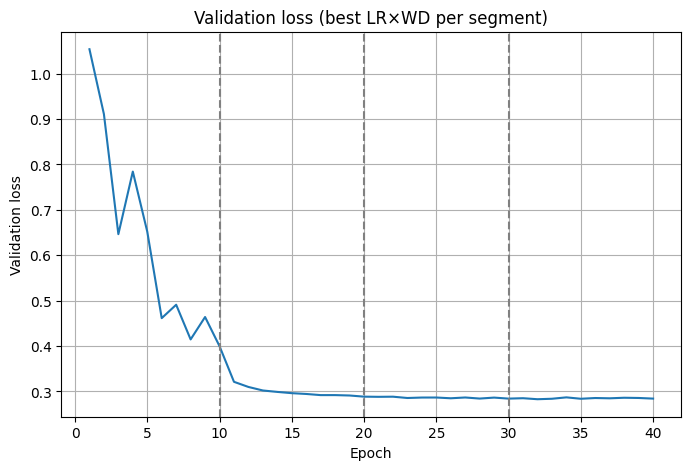


Best LR × WD per segment:
  Segment 1: lr=0.001, wd=0.01
  Segment 2: lr=1e-05, wd=0.01
  Segment 3: lr=1e-05, wd=0
  Segment 4: lr=1e-05, wd=0


In [ ]:
# ===== Staged LR × WD Search over segments, continuing from best weights =====
import os, json, copy, time, torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models

try:
    from muon import SingleDeviceMuonWithAuxAdam as MuonWrapper
except Exception:
    from muon import MuonWithAuxAdam as MuonWrapper

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Model (ResNet-18 for CIFAR10) ---
def resnet18_cifar(num_classes=10):
    m = models.resnet18(weights=None)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

criterion = nn.CrossEntropyLoss()

@torch.no_grad()
def eval_loss_and_acc(model):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    for x, y in testloader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += loss.item() * y.size(0)
        correct  += (logits.argmax(1) == y).sum().item()
        total    += y.size(0)
    return loss_sum / total, correct / total

def build_optimizer(model, lr_muon, lr_aux, wd):
    muon_params, aux_params = [], []
    for n, p in model.named_parameters():
        if not p.requires_grad:
            continue
        (muon_params if p.ndim == 2 else aux_params).append(p)
    param_groups = [
        dict(params=muon_params, use_muon=True,  lr=lr_muon, momentum=0.95, weight_decay=wd),
        dict(params=aux_params,  use_muon=False, lr=lr_aux,                 weight_decay=wd),
    ]
    return MuonWrapper(param_groups)

def train_for_epochs(model, optimizer, epochs):
    val_losses = []
    for epoch in range(1, epochs + 1):
        model.train()
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
        vloss, _ = eval_loss_and_acc(model)
        val_losses.append(vloss)
    return val_losses

# ========= Config =========
TOTAL_EPOCHS = 40
SEGMENTS     = 4

LR_GRID = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
WD_GRID = [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

segment_sizes = [TOTAL_EPOCHS // SEGMENTS] * SEGMENTS
segment_sizes[-1] += TOTAL_EPOCHS - sum(segment_sizes)

SAVE_DIR = "./staged_lr_wd_search"
os.makedirs(SAVE_DIR, exist_ok=True)

# ========= Main staged search =========
current_model = resnet18_cifar().to(device)
torch.save(current_model.state_dict(), os.path.join(SAVE_DIR, "init_state.pth"))

stitched_val_loss = []
best_hparams_by_segment = []  # list of (lr, wd)

for seg_idx, seg_epochs in enumerate(segment_sizes, start=1):

    print(f"\n=== Segment {seg_idx}/{SEGMENTS} | epochs={seg_epochs} ===")
    base_state = copy.deepcopy(current_model.state_dict())

    # Storage
    per_trial_hist   = {}   # (lr, wd) -> [val losses]
    per_trial_loss   = {}   # (lr, wd) -> final vloss
    per_trial_state  = {}   # (lr, wd) -> state dict

    # Grid search for this segment
    for lr in LR_GRID:
        for wd in WD_GRID:

            # Reset model weights
            trial_model = resnet18_cifar().to(device)
            trial_model.load_state_dict(base_state)

            optimizer = build_optimizer(trial_model, lr_muon=lr, lr_aux=lr, wd=wd)

            t0 = time.time()
            val_losses = train_for_epochs(trial_model, optimizer, seg_epochs)
            elapsed = time.time() - t0

            final_vloss = val_losses[-1]

            key = (lr, wd)
            per_trial_hist[key]  = val_losses
            per_trial_loss[key]  = final_vloss
            per_trial_state[key] = copy.deepcopy(trial_model.state_dict())

            # Save trial artifacts
            tag = f"seg{seg_idx}_lr{lr}_wd{wd}"
            torch.save(
                {"segment": seg_idx, "epochs": seg_epochs,
                 "lr": lr, "wd": wd,
                 "val_losses": val_losses, "final_vloss": final_vloss,
                 "time_sec": elapsed},
                os.path.join(SAVE_DIR, f"{tag}.pt")
            )
            with open(os.path.join(SAVE_DIR, f"{tag}.json"), "w") as f:
                json.dump(
                    {"segment": seg_idx, "epochs": seg_epochs,
                     "lr": lr, "wd": wd,
                     "val_losses": [float(v) for v in val_losses],
                     "final_vloss": float(final_vloss),
                     "time_sec": elapsed},
                    f, indent=2
                )

            print(f"  lr={lr:g}, wd={wd:g} | final vloss={final_vloss:.4f} | saved {tag}")

    # ---- Pick winner ----
    best_lr, best_wd = min(per_trial_loss.keys(), key=lambda k: per_trial_loss[k])
    best_hparams_by_segment.append((best_lr, best_wd))

    # Load winning weights for next segment
    current_model.load_state_dict(per_trial_state[(best_lr, best_wd)])

    # Add winning curve to stitched curve
    stitched_val_loss.extend(per_trial_hist[(best_lr, best_wd)])

    # Save winning model
    torch.save(current_model.state_dict(),
               os.path.join(SAVE_DIR, f"segment{seg_idx}_winner.pth"))

    print(f"Segment {seg_idx} winner: lr={best_lr:g}, wd={best_wd:g} "
          f"| final vloss={per_trial_loss[(best_lr, best_wd)]:.4f}")

# ========= Plot stitched best-per-segment curve =========
plt.figure(figsize=(8,5))
plt.plot(range(1, len(stitched_val_loss)+1), stitched_val_loss)
cum = 0
for s in segment_sizes[:-1]:
    cum += s
    plt.axvline(cum, color='gray', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Validation loss")
plt.title("Validation loss (best LR×WD per segment)")
plt.grid(True)
plt.show()

print("\nBest LR × WD per segment:")
for i, (lr, wd) in enumerate(best_hparams_by_segment, start=1):
    print(f"  Segment {i}: lr={lr:g}, wd={wd:g}")


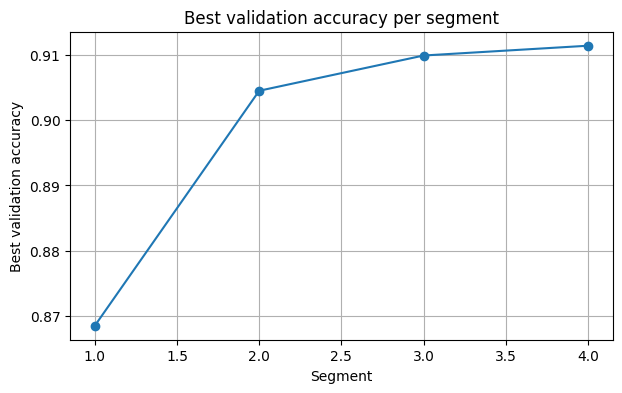

Segment 1: accuracy=0.8685
Segment 2: accuracy=0.9045
Segment 3: accuracy=0.9099
Segment 4: accuracy=0.9114


In [ ]:
import torch
import matplotlib.pyplot as plt
import os

SAVE_DIR = "./staged_lr_wd_search"

best_accs = []

for seg in range(1, 5):  # segments 1–4
    model = resnet18_cifar().to(device)

    winner_path = os.path.join(SAVE_DIR, f"segment{seg}_winner.pth")
    model.load_state_dict(torch.load(winner_path, map_location=device))

    _, acc = eval_loss_and_acc(model)
    best_accs.append(acc)

# Plot
plt.figure(figsize=(7,4))
plt.plot(range(1, len(best_accs)+1), best_accs, marker="o")
plt.xlabel("Segment")
plt.ylabel("Best validation accuracy")
plt.title("Best validation accuracy per segment")
plt.grid(True)
plt.show()

for i, acc in enumerate(best_accs, 1):
    print(f"Segment {i}: accuracy={acc:.4f}")
